# Be best - Lab

In this assignment we study exploration in the very abstract $n$-armed bandit ask. In this there are $n$ actions to take. Each returns a reward $R$, with some probability $p$. The reward value is either a 1 or a 0. This means the expected value of each arm is simply probability. Nice and simple right?

Our agents are really learning, at last. Reinforcement learning, to be precise. 

The reward value $Q$ update rule for all agents (below) and arm is the same:

$$ Q \leftarrow Q + \alpha * (R - Q) $$ [1]

Where the learning rate _lr_reward_ is denoted as $\alpha$, so that the equation above looks nice. The learning rate often gets called $\alpha$ in the reinforcement learning world. If you are not familiar with the idea of a learning rate, it is what it sounds like. A parameter that controls how much each value update matters. This is, over time, the rate at which learning happens.

Remember too that $Q$ is trying to approximate the average reward value of each arm.

This kind of difference $(R - Q)$ in Eq [1] is typical of RL. If you're not sure what it means, consider in your head, what would happen to the value update if $Q$ was bigger than the reward $R$ (and overestimate), or if it was smaller. Once you have noodled that a bit, as needed, consider how making $\alpha$ bigger or smaller might make $Q$ learning faster, or slower, or more or less volatile. (Learning speed and volatility _often_ go together; an annoying matched set.)

_Note_: We are not going to use $\alpha$ here. Just giving you some intuition. We will use it soon...

Our exploration strategies are a random one, a sequential one, or $\epsilon$-greedy (aka 'e'-greedy). 

The random one, and the sequential one, will come in two flavors. One that just explores, with no attempt to exploit. And one who's pure exploration is bound. Bounded by the number of steps of exploration that are allowed. Once that bound is exceeded, then both the Bounded agents will choose the arm they think is most valuable forevermore. Forevermore! 

The lab has two sections. 

- _First_ is a demo mostly. We will explore 4-armed bandits, and get to know our three basic agents.
- _Second_, is where things get more interesting. We'll put $\epsilon$=greedy, and the two bounded agents, in a little competition. The big question is this: tremendous effort has gone in over the years to study bandits when the exploration-exploitation dilemma is in play. The question this week is a doozy: was all work even necessary? 

Or to say it more directly: What is the cost in terms of rewards found to doing pure exploration, with a bound. 

In some ways this is not a fair competition in Section 2. Or really, in many ways. The $\epsilon$-greedy method is not the best known solution to trading off exploration with exploitation. Then again, it is widely used to this day. It's a place to start to ask this, our big question, anyway. We'll come back to it next week, and try to be more fancy.

Our metric is _total reward_. Maximizing that is the goal of all RL, afterall.

## Install and import needed modules

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

In [1]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Our friend, the bandit.

In this section we'll study three explorers getting to know one bandit, with four arms.

### The base case (Section 1)

Let's make a four armed bandit and then plot its values. (Expected value is the term used in the literature, so I will too). 

_Note_: The random seed is fixed. If you change the see and run the cell below, some of the reward probabilities will change. The probability of the best arm, the optimal value arm is fixed however. It is set to 0.35, and located at arm 2. Try it! Rerun the cell below with different seeds, a few times, to get a sense of how the non-optimal arms can vary.

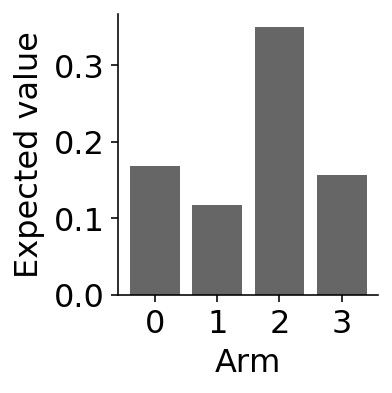

In [3]:
# Shared env params
num_experiments = 1
seed = 5030

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### Our three agents, _unbounded_

A word about the code. Our agents this week work in whaat gets called an ActorCritic desgin. This breaks reinforcement learning algorithms in two two parts, obviously. The Actor does action selection. The Critic estimates the value of each action.

Now in normal reinforcement learning, aka not pure exploration, the _Actor_ uses the $Q$ value estimates from the _Critic_ to, in part, make its decisions. Be it explore or exploit. This is indeed the case for the $\epsilon$-greedy agent, _EpsilonActor_, works. 

...But... 

The other two agents--_SequentialActor_ and _RandomActor_--don't explore with value. The are both _max entropy_ action systems, who don't care about reward value or learning _at all_. I have kept the _ActorCritic_ style because it was easy to implement in _explorationlib_. Don't be misled.

In [4]:
ran = BanditActorCritic(
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
seq = BanditActorCritic(
    SequentialActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

# -
agents = [ran, seq, epy]
names = ["random", "sequential", "ep-greedy"]
colors = ["blue", "green", "purple"]

Let's run out our three agents on the _env_ from our base, and plot some things about them.

In [5]:
num_steps = 12  # Three rounds per arm, about that anyway

# !
results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep-greedy: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


#### Plot action choices 
with time (aka steps).

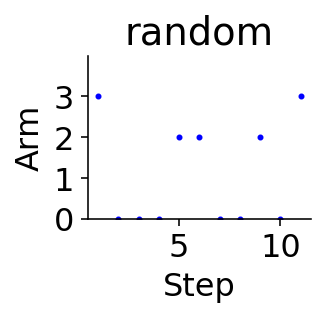

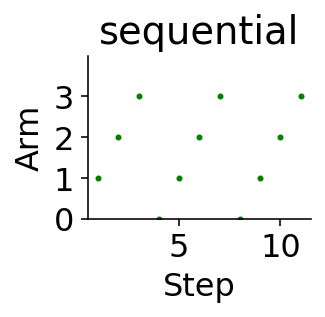

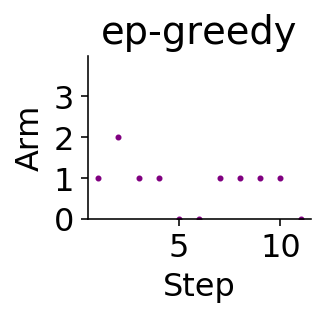

In [6]:
num_experiment = 0
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        num_arms=4,
        s=4,
        title=name, 
        color=color,
        figsize=(2, 1.5)
        )

histograms action probability (aka arm choice). 

_Note_: The flatter these plots are, the closer they are to _maximum entropy_ exploration behavior. I added a measure of the actual entropy to the title of each plot, to make it easier to compare.

action_entropy: 100%|██████████| 1/1 [00:00<00:00, 298.78it/s]


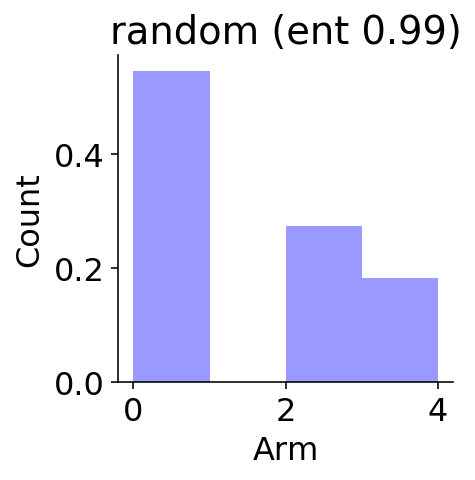

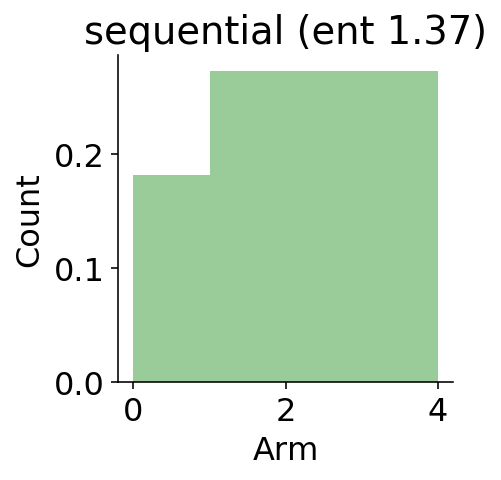

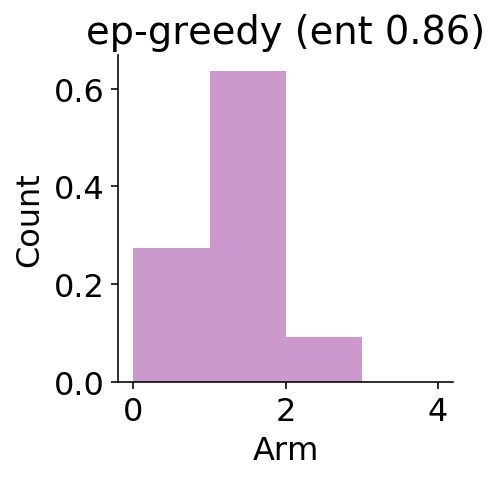

In [9]:
num_experiment = 0
ax = None
for name, res, color in zip(names, results, colors):
    ent = np.round(np.mean(action_entropy(res)), 2)
    plot_bandit_hist(
        select_exp(res, num_experiment), 
        bins=list(range(0, 5)),
        title=f"{name} (ent {ent})", 
        alpha=0.4,
        color=color,
        figsize=(3, 3),
        ax=ax
        )

#### Question 1.1 
How max entropy is max entropy sampling? If we ran the above 100 times, using different random seeds to the env and agents, would the measured entropy of random--who is max entropy asymptotically--ever exceed the sequential explorer?

In [10]:
# Write your answer here, as a comment. Explain yourself.

Let's find out....

In [12]:
scores = []
for name, agent in zip(names[0:2], agents[0:2]):
    tmp = []
    for i in range(100):
        env.seed(seed + i)
        exp = experiment(
            f"{name}_{i}",
            agent,
            env,
            num_steps=num_steps,
            num_experiments=1,
            dump=False,
            split_state=False,
        )
        ent = np.mean(action_entropy(exp))
        tmp.append(ent)
    scores.append(tmp)

action_entropy: 100%|██████████| 1/1 [00:00<00:00, 242.89it/s]


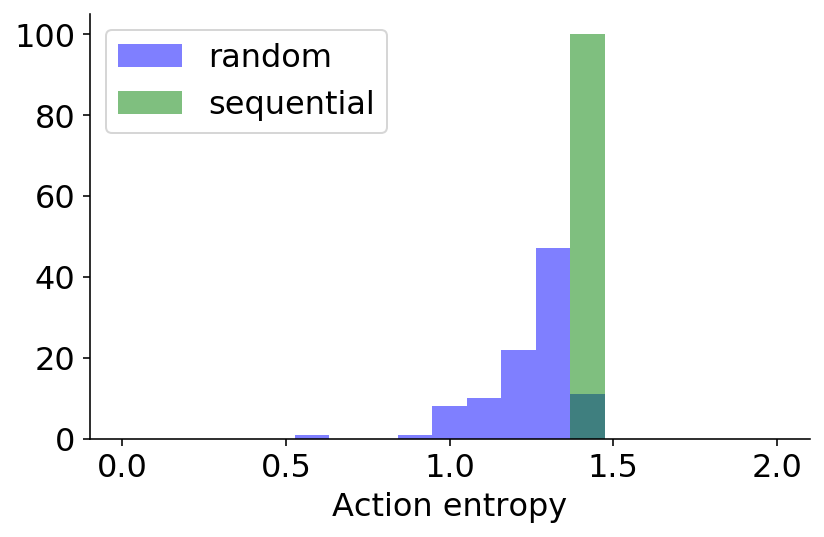

In [13]:
for (name, s, c) in zip(names[0:2], scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, 2, 20))
    plt.legend()
    plt.xlabel("Action entropy")
    plt.tight_layout()
    sns.despine()

#### Question 1.2
Was your guess in Question 1.1 right? If it was, good job. If your guess was wrong, do you know why? Explain as best you can please.

In [14]:
# Write your answer here, as a comment. Explain yourself.

#### Question 1.3
Given what you have seen in Question 1.1, does random sampling seem more lesss like a good idea than sequential sampling. In other words, if you had to pick one be your own personal bandit explorer, which one would it be? 

In [15]:
# Write your answer here, as a comment. Explain yourself.

#### Meet our dilemma
Should I explore? Should I exploit it!? OMG I DON'T KNOW, says space crab.

....I'll flip a weight coin, 

...who's weight has a name. It's $\epsilon$! 

The smaller $\epsilon$ is, the less likely the coin flip comes up "EXPLORE''. The more likely it comes up on the "EXPLOIT" side. If one chooses the exploit side, one is being greedy, right? The bigger $\epsilon$ the more likely the coin will say "EXPLORE ''. Etc.

Let's play with $\epsilon$-greedy, on our base case.

In [28]:
num_steps = 4 * 100
epsilons = [0.05, 0.5, 0.95]

names = [str(epsilon) for epsilon in epsilons]
colors = ["mediumpurple", "mediumorchid", "mediumvioletred"]

# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=100,
        dump=False,
        split_state=False,
    )
    results.append(log)

ep_0: 100%|██████████| 100/100 [00:06<00:00, 16.04it/s]


Example behave. Change _num experiment_ to see more examples (0, 99). 

_Note_: in every experiment we run in this lab, the optimal value arm is _always_ arm 2.

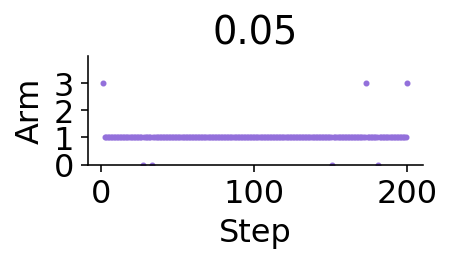

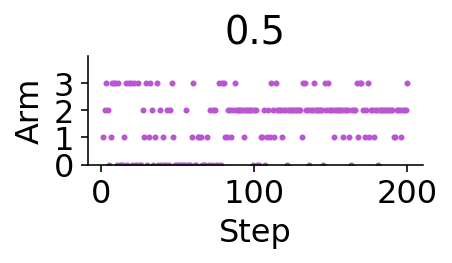

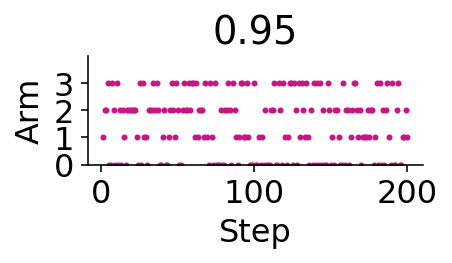

In [29]:
num_experiment = 40
for name, res, color in zip(names, results, colors):
    plot_bandit_actions(
        select_exp(res, num_experiment), 
        max_steps=200,
        s=4,
        title=name, 
        color=color,
        figsize=(3, 1)
        )

Total reward 

total_reward: 100%|██████████| 100/100 [00:00<00:00, 11767.54it/s]


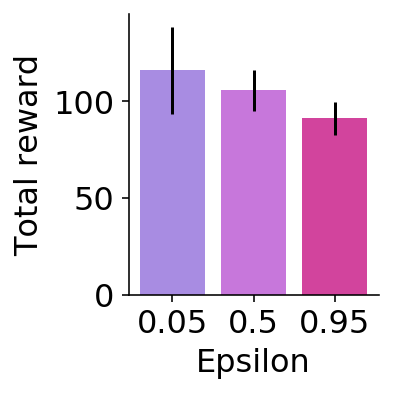

In [43]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

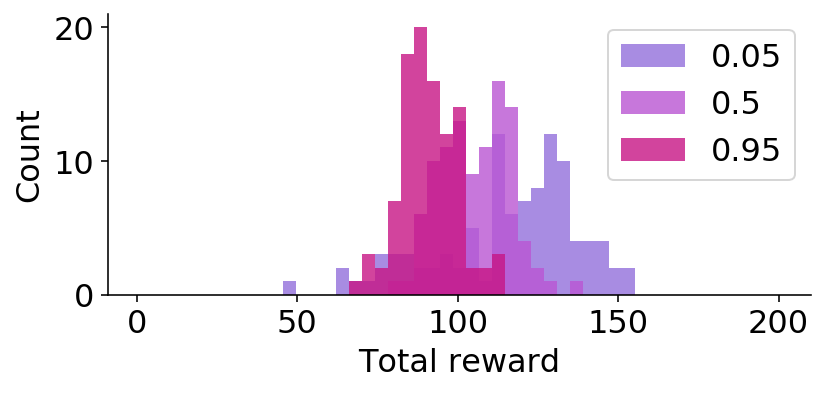

In [44]:
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.8, bins=np.linspace(1, 200, 50))
    plt.legend()
    plt.xlabel("Total reward")
    plt.ylabel("Count")
    plt.tight_layout()
    sns.despine()

Action entropy

action_entropy: 100%|██████████| 100/100 [00:00<00:00, 4930.70it/s]


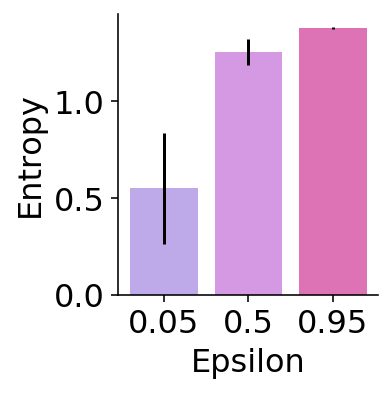

In [45]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = action_entropy(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Entropy")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

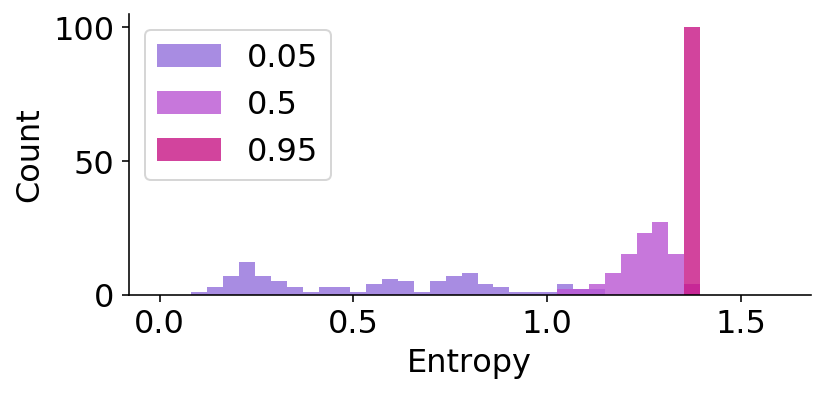

In [52]:
fig = plt.figure(figsize=(6, 3))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.8, bins=np.linspace(0, 1.6, 40))
    plt.legend()
    plt.xlabel("Entropy")
    plt.ylabel("Count")
    plt.tight_layout()
    sns.despine()

#### Question 1.4
In your own words explain how $\epsilon$ seems to relate to _total reward_ and _action entropy_. As $\epsilon$ grows, what happens?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

#### Question 1.5
Let's ask this again from another direction. What relationship do you see between _total reward_ and _action entropy_? To answer focus on the the two bar plots above, perhaps. 

Can you explain this correlation in terms of explore-exploit, and the bandit problem we are trying to understand/solve? Is it strong or weak? Can you say why?

In [20]:
# Write your answer here, as a comment. Explain yourself.

## Section 2 - Bounds and bandits

In this section we'll study two pure explorers with bounds. Our friend $\epsilon$-greedy returns, unchanged. Our friend $\epsilon$-greedy is a proxy for the question, "Does the explore-exploit dilemma even matter, for bandits?" We are going to give a (very very very) incomplete answer to this question by first tuning up our agents as best we can. Then, we put them in competition.

#### Question 2.1
Take a wild guess. Speculate. Use what little this lab has so far shown you. Does the dilemma matter? Will our friend $\epsilon$-greedy emerge the winner?

In [48]:
# Write your answer here, as a comment. Explain yourself.

### Our (training) base case (Section 2)

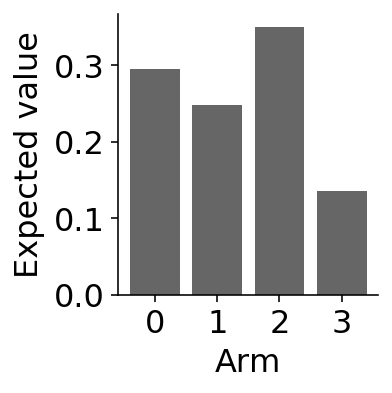

In [52]:
# DO NOT CHANGE:

# Shared env params
num_experiments = 100
seed = 593  

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

### A tune up
Let's tune up each bandit, assuming 400 steps is an ok number.

In [71]:
num_steps = 4 * 100
num_experiments = 250

#### Question 2.2 - Ep tuning.

What is the best $\epsilon$? (For this task).

The code below is a first try at tuning _EpsilonActor_ and it's only parameter $\epsilon$. Run it. Then use the code to try and narrow down a best choice for $\epsilon$ in this environment. Put each attempt you make in a new cell, as a way to show your work. (Do not change _num steps_ or _num experiments_, above).

total_reward: 100%|██████████| 250/250 [00:00<00:00, 12580.55it/s]


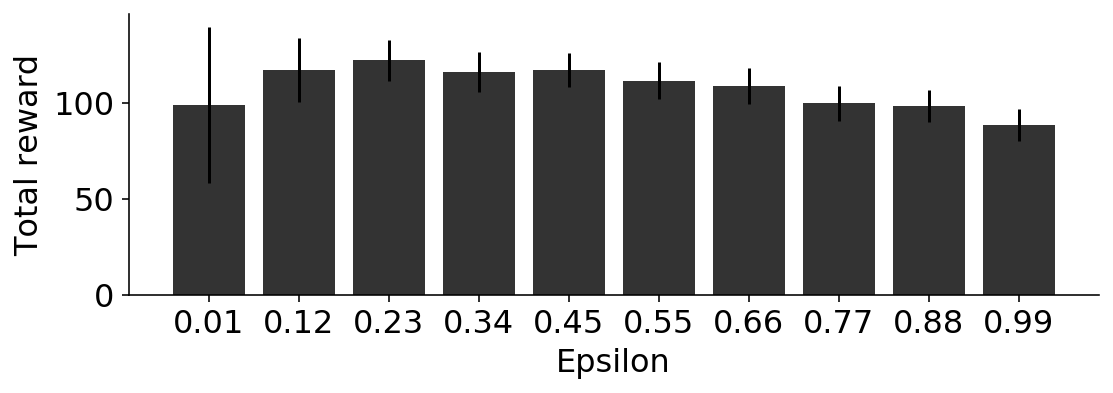

In [73]:
# CHANGE ME
start = 0.01 # min 0
stop = 0.99 # max 1
num_search = 10 # ?

# -
# LEAVE ME
epsilons = np.linspace(start, stop, num_search)
names = [str(np.round(epsilon, 2)) for epsilon in epsilons]

# !
results = []
for i, (name, epsilon) in enumerate(zip(names, epsilons)):
    agent = BanditActorCritic(
        EpsilonActor(num_actions=env.num_arms, epsilon=epsilon),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"ep_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Epsilon")
plt.tight_layout()
sns.despine()

In [69]:
# Your code goes here; Find the best ep!

In [ ]:
# When you are done, write the best ep you found here as a comment

### Question 2.4 

In the next question we'll tune the bound; the number of pure exploration steps before pure exploitation begins. But first, let's just the random pure explorer in action.

Starting from 100, change the _bound_ below a few times, and plot the results-behave examples and reward distributions. Tell me what happens as the bound shrinks to 4 (aka one sample / arm, on average).

_Note_: you can eyeball this, as I suggest, but it might be easier to write your own 'for loop' to see for sure?

In [106]:
bound = 100 # max 100
ran = BanditActorCritic(
    BoundedRandomActor(num_actions=env.num_arms, bound=bound),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)
exp = experiment(
        f"example_bound",
        ran,
        env,
        num_steps=200,
        num_experiments=100,
        dump=False,
        split_state=False,
    )

example_bound: 100%|██████████| 100/100 [00:01<00:00, 93.77it/s]


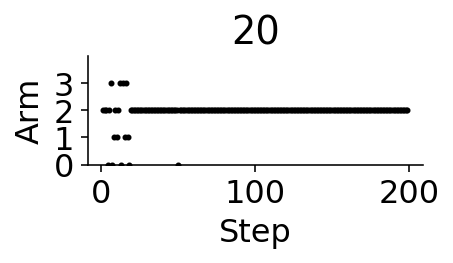

In [104]:
plot_bandit_actions(
        select_exp(exp, 0), 
        max_steps=200,
        s=4,
        title=bound, 
        color="black",
        figsize=(3, 1)
)

total_reward: 100%|██████████| 100/100 [00:00<00:00, 25495.74it/s]


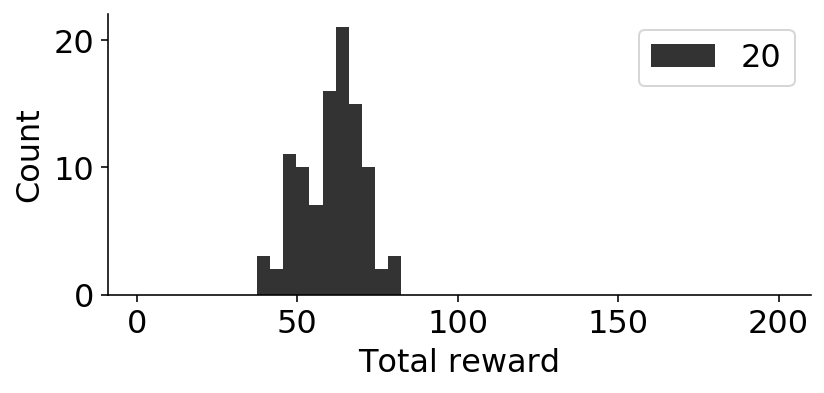

In [105]:
fig = plt.figure(figsize=(6, 3))
plt.hist(total_reward(exp), label=bound, color="black", alpha=0.8, bins=np.linspace(1, 200, 50))
plt.legend()
plt.xlabel("Total reward")
plt.ylabel("Count")
plt.tight_layout()
sns.despine()

In [ ]:
# Write your answer here, as a comment. Explain yourself.

#### Question 2.5
What is the best _bound_ (For this task).

The code below is a first try at tuning _BoundedRandomActor_ and its only parameter _bound_. Run it. Then use the code to try and narrrow down a best choice for $\epsilon$ at this environment. Put each attempt you make in a new cell, as a way to show your work. (Do not change _num steps_ or _num experiments_, above).

total_reward: 100%|██████████| 250/250 [00:00<00:00, 9822.82it/s]


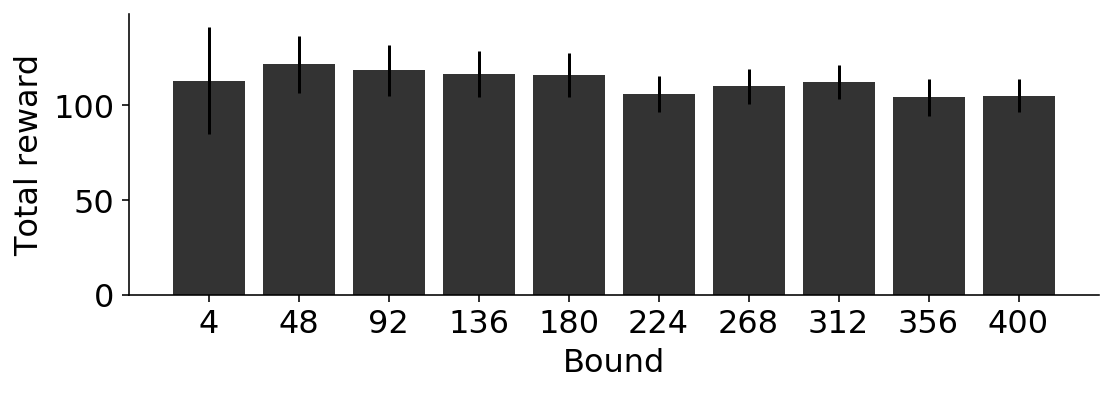

In [78]:
# CHANGE ME
start = 4 # min 4
stop = num_steps # max num_steps
num_search = 10 # ?

# -
# LEAVE ME
bounds = np.linspace(start, stop, num_search).astype(int)
names = [str(np.round(bound, 2)) for bound in bounds]

# !
results = []
for i, (name, bound) in enumerate(zip(names, bounds)):
    agent = BanditActorCritic(
        BoundedRandomActor(num_actions=env.num_arms, bound=bound),
        Critic(num_inputs=env.num_arms, default_value=0.0)
    )
    log = experiment(
        f"b_{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        dump=False,
        split_state=False,
    )
    results.append(log)

# Score
scores = []
for name, res in zip(names, results):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s) in zip(names, scores):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot
fig = plt.figure(figsize=(8, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Bound")
plt.tight_layout()
sns.despine()

In [ ]:
# Your code goes here; Find the best bound!

In [ ]:
# When you are done, write the best bound you found here as a comment

#### Question 2.6
Note: we are only going to tune the bound for _BoundedRandomActor_, and we'll rercycle this for _BoundedSequentialActor_. Can you guess why we are not optimizing both?

In [ ]:
# Write your answer here, as a comment. Explain yourself.

### Our reporting base case (Section 2)

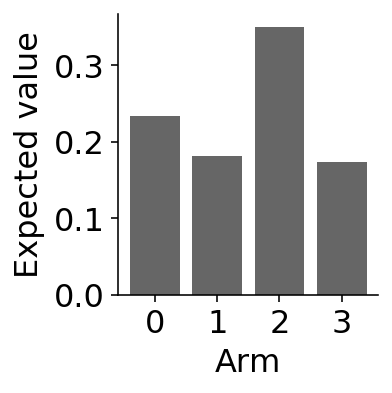

In [83]:
# DO NOT CHANGE:

# Shared env params
seed = 195

# Create env
env = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.35)
env.seed(seed)

# Plot env
plot_bandit(env, alpha=0.6)

#### Question 2.7

So, what's a better way to maximize total reward in this (reporting) task? Is it BoundedRandomActor? Or, BoundedSeqentialActor? Or is it _EpsilonActor_?

To answer, use the optimized parameters from Q2.2-6 to run a series of experiments, with a variable number of steps. Report the total rewards collected for each of the three agents for the num_steps below. I am not going to do any work for you this time. You're on your own for the code!

In [ ]:
num_steps = [4, 8, 16, 40, 80, 200, 400, 1000, 2000]

In [85]:
# Your code goes here; Find the best agent for each num_steps.

In [86]:
# When you are done, write the best agent here

#### Question 2.8 - the big conclusion!

Based on what you've seen here today, do you think pure exploration is a good way to solve reward learning problems? Assume when you answer that our 4-armed bandit is a good proxy for the real world.

In [ ]:
# Write your answer here, as a comment. Explain yourself.